# Import

In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Predicción______________________________

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
y_train = pd.read_csv('dades/processed/training_label.csv', index_col='index')

X_val1 = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
y_val1 = pd.read_csv('dades/processed/validation_label.csv', index_col='index')

X_val2 = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
y_val2 = pd.read_csv('dades/processed/testing_label.csv', index_col='index')


CPU times: user 9.59 s, sys: 1.03 s, total: 10.6 s
Wall time: 10.6 s


# Run pipeline

In [5]:
%%time 

np.abs(
    X_train.drop(
        columns=[
            'num_docks_available',
            'timestamp',
            'num_bikes_available_types.ebike',
            'num_bikes_available_types.mechanical',
            'num_bikes_available',
            'is_returning',
            'is_renting',
            'status'
        ]
    ).corr(method='pearson').ctx0
).sort_values(ascending=False)

# num_docks_available, timestamp

# num_docks_available                     0.880782
# timestamp                               0.024289
# num_bikes_available_types.ebike        -0.393887
# num_bikes_available_types.mechanical   -0.755995
# num_bikes_available                    -0.865541
# is_returning                            0.006442
# is_renting                              0.006442
# status                                  0.006277

CPU times: user 1.95 s, sys: 94.5 ms, total: 2.05 s
Wall time: 2.04 s


ctx0               1.000000
ctx1               0.896549
ctx2               0.764094
ctx3               0.647742
ctx4               0.543951
station_id         0.055505
capacity           0.029374
dayofyear          0.024225
month              0.024205
weekend            0.023917
hour               0.023584
dayofweek          0.019885
festius_sun        0.017032
festius_sun_sat    0.016813
festius            0.007159
day                0.003706
year                    NaN
Name: ctx0, dtype: float64

In [6]:
class Config:
    num_attribs0 = ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['month', 'dayofyear', 'dayofweek', 'day', 'hour']
    cat_attribs1 = ['station_id']
    gen_attribs0 = ['year', 'festius_sun', 'weekend']
    target_col = ['ctx0']

    epochs=50
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [9]:
config=Config()
seed_everything(config.seed)

In [10]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [11]:
%%time 

full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
X_val_prepared2 = full_pipeline.transform(X_val2)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",X_val_prepared1.shape,"y_test: ",y_val1.shape)
print("x_test_prepared:",X_val_prepared2.shape,"y_test: ",y_val2.shape)


x_train_prepared: (3541851, 421) y_train:  (3541851, 1)
x_test_prepared: (882910, 421) y_test:  (882910, 1)
x_test_prepared: (1694015, 421) y_test:  (1694015, 1)
CPU times: user 3.88 s, sys: 639 ms, total: 4.51 s
Wall time: 4.51 s


# ML Models

## LinearRegression

In [12]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,X_train_prepared, y_train,'Linear Regression')

# Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303


  Linear Regression
Scores: [0.81366649 0.81714846 0.81319332 0.81487188 0.81653207]
Mean: 0.8150824420890652
Standard deviation: 0.0015484131995692416
CPU times: user 1min 6s, sys: 3min 41s, total: 4min 48s
Wall time: 21 s


In [13]:
%%time 

lin_reg.fit(X_train_prepared,y_train)

CPU times: user 12.8 s, sys: 40.1 s, total: 52.8 s
Wall time: 4.13 s


LinearRegression()


Training time: 0.076 s
----- EVALUATION ON VAL SET ------
MSE: 0.012617917699687172
RMSE 0.11232950502733986
MAE: 0.07492697431990272
R^2:  0.8151279546020399



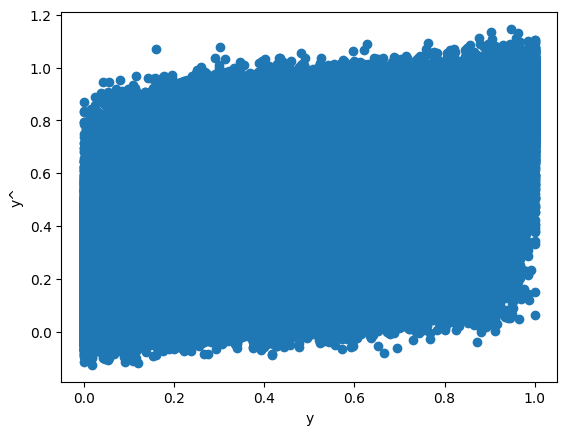

y_hat_t    [[0.5927943617149684], [0.5949898046741815], [...
mse_t                                               0.012618
rmse_t                                               0.11233
mae_t                                               0.074927
r2_t                                                0.815128
dtype: object

In [14]:
test_model(lin_reg, X_train_prepared, y_train)


Training time: 0.016 s
----- EVALUATION ON VAL SET ------
MSE: 0.009228882237622697
RMSE 0.09606707155744208
MAE: 0.0650526230105263
R^2:  0.857979876334832



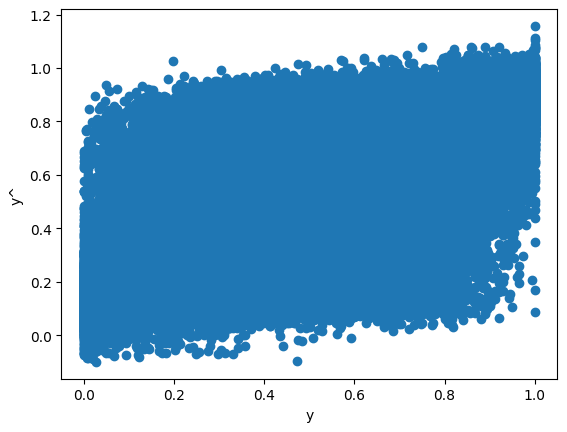


Testing time: 0.03 s
----- EVALUATION ON VAL SET ------
MSE: 0.013045866739203762
RMSE 0.11421850436423935
MAE: 0.07726240816833273
R^2:  0.8186494017258769



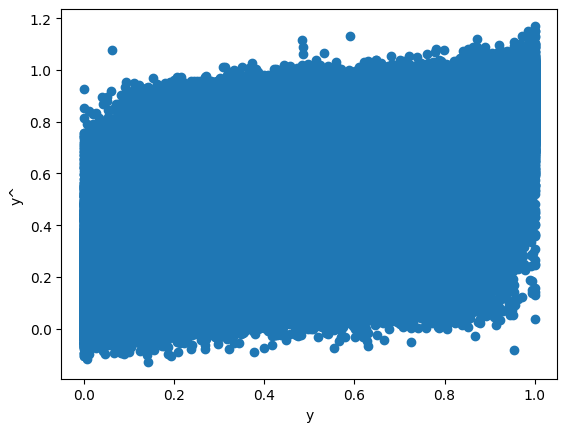

y_hat_t    [[0.8085617031324348], [0.7284428125126428], [...
mse_t                                               0.009229
rmse_t                                              0.096067
mae_t                                               0.065053
r2_t                                                 0.85798
y_hat_v    [[0.2046283794498856], [0.20835540496394955], ...
mse_v                                               0.013046
rmse_v                                              0.114219
mae_v                                               0.077262
r2_v                                                0.818649
dtype: object

In [15]:
test_model(lin_reg, X_val_prepared1, y_val1, X_val_prepared2, y_val2)

## KNN3

In [ ]:
%%time 

knn_reg = neighbors.KNeighborsRegressor(3)
# cross_val_evaluation(knn_reg,X_train_prepared, y_train,'KNN Regression')


2023-06-10 19:12:01,460 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-06-10 19:12:01,460 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-06-10 19:12:01,460 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-06-10 19:12:01,460 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-06-10 19:12:01,460 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/homeros/miniconda3/envs/rcnn/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/homeros/miniconda3/envs/rcnn/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/d

In [70]:
%%time 

knn_reg.fit(X_train_prepared,y_train)

CPU times: user 14.1 s, sys: 39 s, total: 53 s
Wall time: 4.29 s


LinearRegression()


Training time: 0.082 s
----- EVALUATION ON VAL SET ------
MSE: 0.012617917699687172
RMSE 0.11232950502733986
MAE: 0.07492697431990272
R^2:  0.8151279546020399



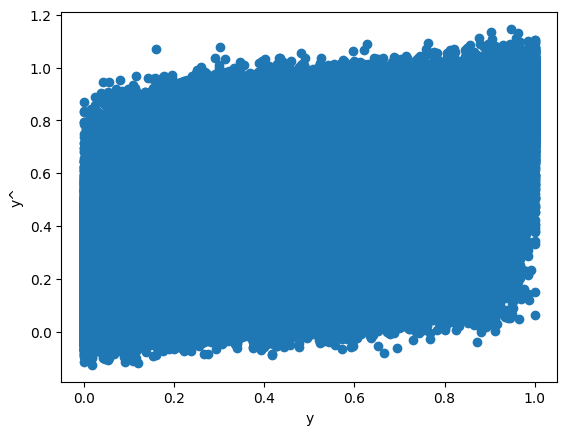

y_hat_t    [0.5927943617149684, 0.5949898046741815, 0.595...
mse_t                                               0.012618
rmse_t                                               0.11233
mae_t                                               0.074927
r2_t                                                0.815128
dtype: object

In [71]:
test_model(knn_reg, X_train_prepared, y_train)


Training time: 0.032 s
----- EVALUATION ON VAL SET ------
MSE: 0.009228882237622697
RMSE 0.09606707155744208
MAE: 0.0650526230105263
R^2:  0.857979876334832



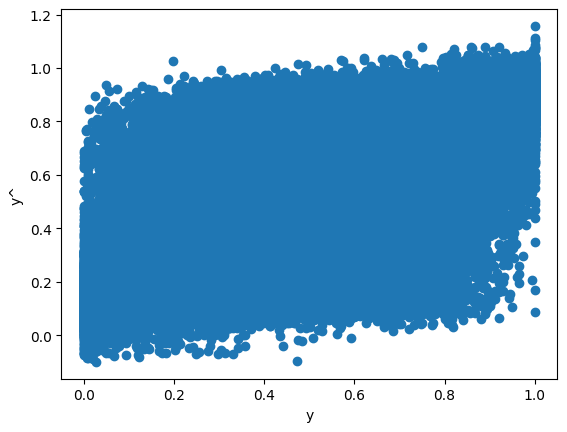


Testing time: 0.031 s
----- EVALUATION ON VAL SET ------
MSE: 0.013045866739203762
RMSE 0.11421850436423935
MAE: 0.07726240816833273
R^2:  0.8186494017258769



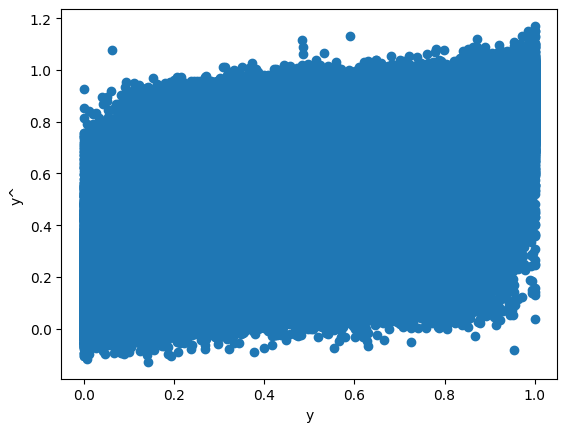

y_hat_t    [0.8085617031324348, 0.7284428125126428, 0.840...
mse_t                                               0.009229
rmse_t                                              0.096067
mae_t                                               0.065053
r2_t                                                 0.85798
y_hat_v    [0.2046283794498856, 0.20835540496394955, 0.28...
mse_v                                               0.013046
rmse_v                                              0.114219
mae_v                                               0.077262
r2_v                                                0.818649
dtype: object

In [72]:
test_model(knn_reg, X_val_prepared1, y_val1, X_val_prepared2, y_val2)

## SVM 

## Random forest

## Gradiend Boosting

## NN 

In [ ]:
import tensorflow as tf
from tensorflow import keras
print(keras.__version__)
print(tf.__version__)
print(tf.test.gpu_device_name())

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import concurrent.futures
import logging
import sys
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras import backend as K
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=3,
    inter_op_parallelism_threads=3
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau

In [ ]:
X_train_prepared.shape[1] # 408 + 11 

In [ ]:
# indicate the input shape
input_shape = X_train_prepared.shape[1]
print(input_shape)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    y = K.cast(y_true, K.np.float32)
    y_hat = K.cast(y_pred, K.np.float32)
    return K.sqrt(K.mean(K.square(y_hat - y)))

In [ ]:
from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

final_model = keras.models.Sequential([
    keras.layers.Input(
        shape=(input_shape,)
    ),
    keras.layers.Dense(
        input_shape//0.65, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001),
            kernel_constraint=keras.constraints.MaxNorm(3)
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        input_shape//0.75, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001),
        kernel_constraint=keras.constraints.MaxNorm(3)
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        input_shape//2, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001),
        kernel_constraint=keras.constraints.MaxNorm(3)
    ),
    keras.layers.Dense(1)
])

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
    loss=root_mean_squared_error,
    metrics=[
        'RootMeanSquaredError',
        'MeanAbsoluteError',
        'MeanSquaredError'       
    ]
)

# tensorboard=TensorBoard(log_dir="Model_log")
# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("./checkpoints/year_22_nn.h5", verbose=2, monitor='val_loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=2, restore_best_weights=True)

# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Track the score on the validation set
    patience=7,  # Number of epochs in which no improvement is seen.
    verbose=2,
    factor=0.8,  # Factor by which the LR is multiplied.
    min_lr=0.0000001  # Don't go below this value for LR.
)

In [ ]:
final_model.summary()

In [ ]:
keras.utils.plot_model(final_model, "model.png", show_shapes=True)

In [ ]:
history = final_model.fit(X_train_array, y_train, epochs=config.epochs, validation_data=(X_val1_array, y_val1), callbacks=[checkpoint_cb, early_stopping_cb, learning_rate_reduction]) # tensorboard


In [ ]:
# x_train_prepared: (3541851, 419) y_train:  (3541851,)
# x_test_prepared: (882910, 419) y_test:  (882910,)
# x_test_prepared: (1694015, 419) y_test:  (1694015,)

In [ ]:
%%time

X_val2_array =  X_val_prepared2.toarray()


## Generate Sample

In [ ]:
sample_data = pd.read_csv('dades/metadata_sample_submission.csv/metadata_sample_submission.csv')

In [ ]:
sample_data['year'] = 2023

In [ ]:
sample_data['datetime'] = pd.to_datetime(sample_data[['year','month','day']])
sample_data['dayofweek'] = sample_data.datetime.dt.dayofweek


In [ ]:
sample_data.drop(['datetime', 'index'], axis=1, inplace=True)

In [ ]:
sample_data.rename(
    columns = {
        'ctx-4':'ctx4',
        'ctx-3':'ctx3',
        'ctx-2':'ctx2',
        'ctx-1':'ctx1'
    },
    inplace=True
)

In [ ]:
sample_data

In [ ]:
full_pipeline = build_preprocessor(config)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared1 = full_pipeline.transform(X_val1)
X_val_prepared2 = full_pipeline.transform(X_val2)
X_test_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
print("x_test_prepared:",x_val_prepared.shape,"y_test: ",y_val.shape)
print("x_test_prepared:",x_test_prepared.shape)

In [ ]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')


In [ ]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_val_prepared, y_val)

In [ ]:
yhat = lin_reg.predict(x_test_prepared)


In [ ]:
yhat.shape

In [ ]:
sample_data['percentage_docks_available'] = yhat

In [ ]:
sample_data['percentage_docks_available'].to_csv('predicton_lr.csv', header=True)